# Imports and Setup

In [ ]:
import numpy as np
import os
import librosa as lr
import h5py
import soundfile as sf
import pandas as pd
import re
from scipy.signal import savgol_filter
import wave
from scipy import interpolate
from scipy.stats import zscore
import json
import torchaudio
from collections import Counter
import scipy 
import torch
import matplotlib.pyplot as plt
import shutil


print(f"Current Working Directory: {os.getcwd()}")

audio_data_path = "../data/MSP_Podcast_Corpus/Audio/"
json_labels = "../data/MSP_Podcast_Corpus/Labels/labels_detailed.json"

abs_audio_path = os.path.abspath(audio_data_path)
abs_json_path = os.path.abspath(json_labels)

print(f"\nAudio Path resolves to: {abs_audio_path}")
print(f"Exists? {os.path.exists(abs_audio_path)}")

print(f"\nJSON Labels resolve to: {abs_json_path}")
print(f"Exists? {os.path.exists(abs_json_path)}")

# Data Loading and Statistics
Iterate through the audio directory to load wav files.
Calculate and print statistics about the audio files, such as total count, duration (min, max, mean), and sample rate.

In [ ]:
# data=[]
file_names=[]
samples=[]
durations=[]


for path in os.listdir(audio_data_path):
    if path[-3:]=="wav":
        file_path=os.path.join(audio_data_path, path)
        file_names.append(path)
        y,sr=sf.read(file_path)
        # print(sr)
        durations.append((len(y)/sr))
        # if durations!=0:
        #    print(f"Running mean: {np.mean(np.array(durations))}")
        break
        # samples.append(y)
max_duration=np.max(np.array(durations))
print(f'Es sind {len(file_names)} Dateien geladen worden.')
print(f'Die Längste Datei ist {np.max(np.array(durations)):.3f} Sekunden und die kürzeste {np.min(np.array(durations)):.3f} Sekunden lang. Durchschnittlich sind die Dateien {np.mean(np.array(durations)):.3f} Sekunden lang.')
print(f'Die Samplerate ist {sr}.')

# JSON Metadata Creation

Create a JSON file (`msp_podcast_preprocessing.json`) mapping each audio file to its path and transcript.
- `read_and_store_files`: Reads audio paths and corresponding transcripts.
- `count_emotions`: Aggregates emotion labels from the detailed JSON labels.
- `get_adv_score_mean`: Calculates mean Arousal, Dominance, and Valence scores.
- `update_json`: Updates the main JSON file with emotion and ADV data.

In [ ]:
'''
Angry		(A)
Sad			(S)
Happy		(H)
Surprise	(U)
Fear		(F)
Disgust		(D)
Contempt	(C)
Neutral		(N)
Other		(O)
'''

class create_json:
    def __init__(self, audio_data_path, transcript_folder_path, json_file_name, json_labels):
        self.audio_data_path = audio_data_path
        self.transcript_folder_path = transcript_folder_path
        self.json_file_name = json_file_name
        self.json_labels = json_labels
        self.json_files = {}
        self.file_names = []
        self.samples = []
        self.durations = []
    

    def read_and_store_files(self):
        for path in os.listdir(self.audio_data_path):
            if path[-3:] == "wav":
                file_path = os.path.join(self.audio_data_path, path)
                txt_file_path = os.path.join(self.transcript_folder_path, path.replace(".wav", ".txt"))
                try:
                    with open(txt_file_path, 'r') as file:
                        txt_file = file.read()
                except Exception as e:
                    print(f"Error: {e}")
                    continue
                txt_file = txt_file.replace("'", '"').replace("\"", "'").replace("-", "")
                txt_file = re.sub(r'\[.*?\]', '', txt_file)
                self.json_files[path[:-4]] = {"audio_data_path": file_path, "utterance": txt_file}
        
        with open(self.json_file_name, 'w') as f:
            json.dump(self.json_files, f)
    

    def count_emotions(self):
        with open(self.json_labels) as json_data:
            data = json.load(json_data)
            for wav in data:
                primary_emotion = []
                self.file_names.append(wav[:-4])
                for worker in data[wav]:
                    primary_emotion.append(data[wav][worker]["EmoClass_Major"])
                counter = Counter(primary_emotion)
                most_common_element = counter.most_common(1)
                self.json_files[wav[:-4]] = {"emotion_class": most_common_element[0][0]}
        
        return self.json_files
    

    def update_json(self, new_data):
        with open(self.json_file_name) as f:
            data = json.load(f)
        for key, value in new_data.items():
            if key in data:
                data[key].update(value)
        with open(self.json_file_name, 'w') as f:
            json.dump(data, f)
    

    def get_adv_score_mean(self):
        with open(self.json_labels, 'r') as f:
            data = json.load(f)
        adv_data = {}
        for wav in data:
            adv_score = np.zeros((len(data[wav]), 3))
            idx_w = 0
            for worker in data[wav]:
                adv_score[idx_w, 0] = data[wav][worker]["EmoAct"]
                adv_score[idx_w, 1] = data[wav][worker]["EmoDom"]
                adv_score[idx_w, 2] = data[wav][worker]["EmoVal"]
                idx_w += 1
            adv_score_mean = np.round(np.mean(adv_score, axis=0), decimals=3)
            adv_data[wav[:-4]] = {"arousal": adv_score_mean[0], "dominance": adv_score_mean[1], "valence": adv_score_mean[2]}
        
        return adv_data


processor = create_json(audio_data_path, transcript_folder_path, json_file_name, json_labels)
processor.read_and_store_files()
emotion_data = processor.count_emotions()
processor.update_json(emotion_data)
adv_data = processor.get_adv_score_mean()
processor.update_json(adv_data)

### Load basic JSON

In [ ]:
def open_and_assert_data(path):
    with open('msp_podcast_preprocessing.json', 'r') as f:
        data = json.load(f)
        return data
    if isinstance(data, dict):
        print(f"dict of length: {len(data)}")
    elif isinstance(data, list):
        print(f"list of length: {len(data)}")

In [ ]:
''' functions  to calculate statistics on the MSP Podcast Corpus

def calculate_var():
    idx=0
    adv_score = get_adv_score_mean()
    eval_var_emotion_adv = np.zeros((len(data), 3))
    for wav in data:
        eval_var_emotion_adv[idx][0] = np.round(np.std(adv_score[idx, 0])**2, decimals=2)
        eval_var_emotion_adv[idx][1] = np.round(np.std(adv_score[idx, 1])**2, decimals=2)
        eval_var_emotion_adv[idx][2] = np.round(np.std(adv_score[idx, 2])**2, decimals=2)
        idx+=1
    return eval_var_emotion_adv


def calculate_dis(eval_mean_emotion_adv, eval_var_emotion_adv):
    idx=0
    eval_dis_emotion_adv = np.zeros((len(data), 3))
    for wav in data:
        eval_dis_emotion_adv[idx][0] = np.random.normal(loc=eval_mean_emotion_adv[idx][0], scale=eval_var_emotion_adv[idx][0])
        eval_dis_emotion_adv[idx][1] = np.random.normal(loc=eval_mean_emotion_adv[idx][1], scale=eval_var_emotion_adv[idx][1])
        eval_dis_emotion_adv[idx][2] = np.random.normal(loc=eval_mean_emotion_adv[idx][2], scale=eval_var_emotion_adv[idx][2])
        idx+=1
    return np.round(eval_dis_emotion_adv, decimals=2)
'''

### Time domain features adapted from https://maelfabien.github.io/machinelearning/Speech9/#

In [ ]:
def compute_stats(freqs):
    mean = np.mean(freqs)
    std = np.std(freqs) 
    min = np.min(freqs)
    max = np.max(freqs)
    maxv = np.amax(freqs) 
    minv = np.amin(freqs) 
    median = np.median(freqs)
    cov=np.cov(freqs)
    var=np.var(freqs)
    rms=np.sqrt(np.mean(np.square(freqs)))
    skew = scipy.stats.skew(freqs)
    kurt = scipy.stats.kurtosis(freqs)
    q1 = np.quantile(freqs, 0.25)
    q2 = np.quantile(freqs, 0.5)
    q3 = np.quantile(freqs, 0.75)
    mode = scipy.stats.mode(freqs)[0][0]
    iqr = scipy.stats.iqr(freqs)
    return [min, max, mean, median, mode, std, cov, var, rms, q1, q2, q3]

# Visualization Functions
Define functions to visualize audio features:
- `plot_log_mel_spectrogram`: Plots the Log Mel Spectrogram.
- `plot_mfcc`: Plots the Mel Frequency Cepstral Coefficients.

In [21]:
def plot_log_mel_spectrogram(mel_spec_log, y, sr, path, folder_path_to_save, task):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec_log, origin='lower', aspect='auto', extent=[0, len(y)/sr, 0, sr/2]) # cmap='Spectral'
    plt.colorbar(format='%+2.0f dB')
    plt.title("Log Mel Frequency Spectrogram")
    plt.xlabel('Time in s')
    plt.ylabel('Frequency in Hz')
    plt.tight_layout()

    if task == "plot":
        plt.show()
    elif task == "save":
        plt.savefig(folder_path_to_save + f"{path[:-4]}_log_mel_spectrogram.png")


def plot_mfcc(mfcc, y, sr, n_mfcc, path, folder_path_to_save, task):
    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc, aspect='auto', extent=[0, len(y)/sr, 0, n_mfcc], origin='lower', cmap="Spectral")
    plt.title("Mel Frequency Cepstral Coefficients")
    plt.ylabel('Coefficient')
    plt.xlabel('Time in s')
    plt.tight_layout()

    if task == "plot":
        plt.show()
    elif task == "save":
        plt.savefig(folder_path_to_save + f"{path[:-4]}_mfcc.png")

# Feature Extraction Functions
Define functions to extract various audio features:
- `extract_prosodic_features`: Extracts pitch, RMS energy, and zero-crossing rate.
- `extract_spectral_features`: Extracts MFCCs, spectral contrast, centroids, bandwidth, rolloff, and chroma features.
- `extract_mfcc_spectral_features`: Extracts MFCCs and their deltas/double-deltas.

In [22]:
def extract_prosodic_features(y, sr, n_fft, hop_length, norm, n_mfcc=40, n_mels=40, pre_emp=0.97, fmin_pitch=lr.note_to_hz('A2'), fmax_pitch=lr.note_to_hz('A7')):
    try:
        y = np.append(y[0], y[1:] - pre_emp * y[:-1])
        pitches, magnitudes = lr.core.piptrack(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        pitch = []
        for t in range(pitches.shape[1]):
            index = magnitudes[:, t].argmax()
            pitch.append(pitches[index, t])
        pitch = np.array(pitch)
        pitch = np.array(torch.from_numpy(pitch).unsqueeze(1))
        rms_energy = lr.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)[0]
        rms_energy = np.array(torch.from_numpy(rms_energy).unsqueeze(1))
        zcr = lr.feature.zero_crossing_rate(y=y, frame_length=n_fft, hop_length=hop_length)
        zcr = np.array(torch.from_numpy(zcr).permute(1,0))
        if norm=="zscore":
            pitch = zscore(pitch)
            rms_energy = zscore(rms_energy)
            zcr = zscore(zcr)
        features = np.concatenate((zcr, rms_energy, pitch), axis=1)
        features = np.array(torch.from_numpy(features).permute(1,0))
    except Exception as e:
        print("none",e)
        return None 
    return features


In [23]:
def extract_spectral_features(y, sr, n_fft, hop_length, norm, n_mfcc=13, n_mels=40, pre_emp=0.98, fmin=20, bins_per_octave=12, fmin_pitch=lr.note_to_hz('A2'), fmax_pitch=lr.note_to_hz('A7')):
    try:
        fmax=int(sr/2)
        y = np.append(y[0], y[1:] - pre_emp * y[:-1])
        mfccs = lr.feature.mfcc(y=y, sr=sr,  n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfccs_d = lr.feature.delta(mfccs)
        mfccs_2d = lr.feature.delta(mfccs, order=2)
        spectral_contrast = lr.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        spectral_centroids = lr.feature.spectral_centroid(y=(y+0.001), sr=sr, n_fft=n_fft, hop_length=hop_length)
        spectral_bandwidth = lr.feature.spectral_bandwidth(y=(y+0.001), sr=sr, n_fft=n_fft, hop_length=hop_length)
        spectral_rolloff = lr.feature.spectral_rolloff(y=(y+0.001), sr=sr, n_fft=n_fft, hop_length=hop_length)
        window = scipy.signal.windows.general_hamming(n_fft, alpha=0.46)
        mel = lr.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, norm=2, window=window) 
        log_mel = lr.amplitude_to_db(mel, ref=np.max)
        chromagram = lr.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
        tonnetz = lr.feature.tonnetz(y=lr.effects.harmonic(y), sr=sr, hop_length=hop_length)
        n_bins= int(np.log2(fmax / fmin)* bins_per_octave)-5
        cqt = lr.cqt(y, sr=sr, n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave, hop_length=hop_length)
        log_cqt = lr.amplitude_to_db(np.abs(cqt), ref=np.max)  
        if norm=="zscore":
            tonnetz = zscore(tonnetz, axis=1)
            log_mel = zscore(log_mel, axis=1)
            mfccs = zscore(mfccs, axis=1)
            mfccs_d = zscore(mfccs_d, axis=1)
            mfccs_2d = zscore(mfccs_2d, axis=1)
            spectral_contrast = zscore(spectral_contrast, axis=1)
            spectral_centroids = zscore(spectral_centroids, axis=1)
            spectral_rolloff = zscore(spectral_rolloff, axis=1)
            spectral_bandwidth = zscore(spectral_bandwidth, axis=1)
            chromagram = zscore(chromagram, axis=1)
        features = np.concatenate((log_cqt, mfccs, mfccs_d, spectral_contrast, chromagram), axis=0)
        mfccs_features = np.concatenate((mfccs, mfccs_d, mfccs_d), axis=0)
    except Exception as e:
        print("none",e)
        return None 
    return features, mfccs_features, log_cqt

In [24]:
def extract_mfcc_spectral_features(y, sr, n_fft, hop_length, min_length, n_mfcc=13, n_mels=40, pre_emp=0.98, fmin=20, bins_per_octave=12, fmin_pitch=lr.note_to_hz('A2'), fmax_pitch=lr.note_to_hz('A7')):
    try:
        y_emphasized=lr.effects.preemphasis(y, coef=0.98)
        # y_emphasized = np.append(y[0], y[1:] - pre_emphasis * y[:-1])
        mel_spec = lr.feature.melspectrogram(y=y_emphasized, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, norm=2, window='hamming')
        # mel_spec_log = np.array(lr.power_to_db(mel_spec, ref=np.max).astype(np.float32))
        mfcc = lr.feature.mfcc(S=lr.power_to_db(mel_spec), n_mfcc=n_mfcc)
        mfcc_d = lr.feature.delta(mfcc)
        mfcc_2d = lr.feature.delta(mfcc, order=2)
        features = np.concatenate((mfcc, mfcc_d, mfcc_2d), axis=0)
        sequence_lenght=features.shape[1]
        if sequence_lenght<min_length:
            min_length=sequence_lenght
        features=torch.from_numpy(features).permute(1,0)
    except Exception as e:
        print("none",e)
        return None 
    return features, min_length, mfcc

## Create a folder for visualizations

In [ ]:
folder_path_to_save = "./VisualsMSP_Podcast_DB/"
if os.path.isdir(folder_path_to_save):
    shutil.rmtree(folder_path_to_save)
os.makedirs(folder_path_to_save)

## MFCC Feature Extraction

In [26]:
def feature_extraction_mfcc(x, pre_emphasis=0.98, n_fft=400, hop_length=200, n_mfcc=13, n_mels=40, min_length=0):
    file_names=[]
    samples=[]
    durations=[]
    i=1
    for path in os.listdir(audio_data_path):
        if path[-3:]=="wav":
            file_path=os.path.join(audio_data_path, path)
            file_names.append(path)
            y, sr = lr.load(file_path, sr=16000)
            features, min_length, mfcc = extract_mfcc_spectral_features(y, sr, n_fft, hop_length, min_length)
            plot_mfcc(mfcc, y, sr, n_mfcc, path, folder_path_to_save, task="plot")
            print(features.shape)
            if x>=i:
                i+=1
            else: break        

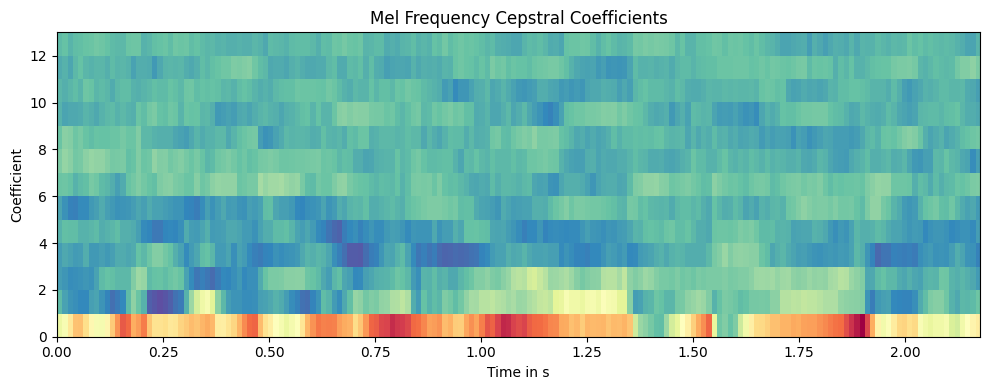

torch.Size([175, 39])


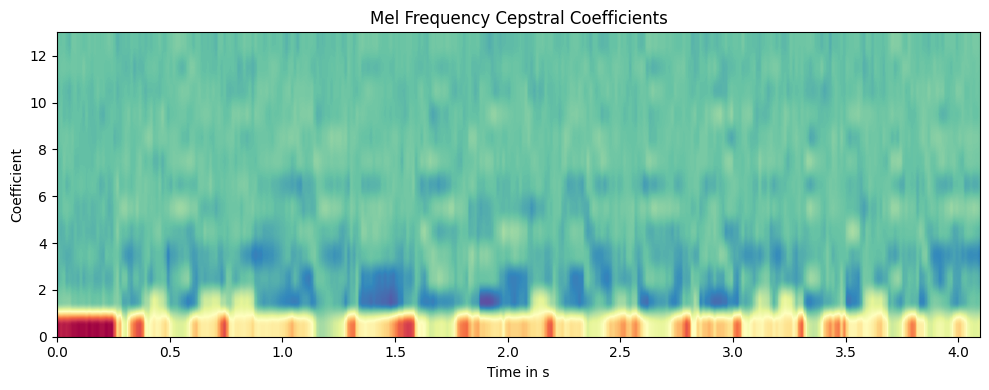

torch.Size([328, 39])


In [27]:
feature_extraction_mfcc(1)

In [ ]:
'''
Angry		(A)
Sad			(S)
Happy		(H)
Surprise	(U)
Fear		(F)
Disgust		(D)
Contempt	(C)
Neutral		(N)
Other		(O)
'''


def create_dataset(existing_data, dataset_name, folder_path, n_fft, hop_length):
    def get_class(emotion):
        if "Angry" in emotion:
            return 0
        if "Sad" in emotion:
            return 1
        if "Happy" in emotion:
            return 2
        if "Surprise" in emotion:
            return 3
        if "Fear" in emotion:
            return 4
        if "Disgust" in emotion:
            return 5
        if "Contempt" in emotion:
            return 6
        if "Neutral" in emotion:
            return 7
        if "Other" in emotion:
            return 8
        else: -1

    # assert dataset_name[-3:]!=".h5"
    # dataset = h5py.File(dataset_name, mode="w", libver="latest")
    train_dataset = h5py.File(("train_"+dataset_name), mode="w", libver="latest")
    valid_dataset = h5py.File(("valid_"+dataset_name), mode="w", libver="latest")
    test_dataset = h5py.File(("test_"+dataset_name), mode="w", libver="latest")
    file_idx=0
    max_length=0
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if file_path[-3:]=="wav":
            path=file[:-4]
            if os.path.isfile(file_path):
                y, sr = lr.load(file_path)
                features, min_length, mfcc = extract_small_spectral_features(y, sr, n_fft, hop_length, max_length)
                if(file_idx==len(os.listdir(folder_path))):
                    print(min_length)
                filename = file.replace(".wav", "")
                if file_idx<=int(0.8*int(len(os.listdir(folder_path)))):
                    h5spec = train_dataset.create_dataset(filename, data=features)
                    if get_class(existing_data[path]["emotion_class"])!=-1:
                        h5spec.attrs["class_label"] = get_class(existing_data[path]["emotion_class"])
                        h5spec.attrs["arousal_score"] = existing_data[path]["arousal"]
                        h5spec.attrs["dominance_score"] = existing_data[path]["dominance"]
                        h5spec.attrs["valence_score"] = existing_data[path]["valence"]
                        h5spec.attrs["utterance"] = existing_data[path]["utterance"]
                        h5spec.attrs["utterance"] = existing_data[path]["utterance"]
                    else: print("error")
                elif (file_idx>int(0.8*int(len(os.listdir(folder_path))))) and (file_idx<=int(0.9*int(len(os.listdir(folder_path))))):
                    h5spec = valid_dataset.create_dataset(filename, data=features)
                    if get_class(existing_data[path]["emotion_class"])!=-1:
                        h5spec.attrs["class_label"] = get_class(existing_data[path]["emotion_class"])
                        h5spec.attrs["arousal_score"] = existing_data[path]["arousal"]
                        h5spec.attrs["dominance_score"] = existing_data[path]["dominance"]
                        h5spec.attrs["valence_score"] = existing_data[path]["valence"]
                        h5spec.attrs["utterance"] = existing_data[path]["utterance"]
                    else: print("error")
                elif file_idx>int(0.9*int(len(os.listdir(folder_path)))): 
                    h5spec = test_dataset.create_dataset(filename, data=features)
                    if get_class(existing_data[path]["emotion_class"])!=-1:
                        h5spec.attrs["class_label"] = get_class(existing_data[path]["emotion_class"])
                        h5spec.attrs["arousal_score"] = existing_data[path]["arousal"]
                        h5spec.attrs["dominance_score"] = existing_data[path]["dominance"]
                        h5spec.attrs["valence_score"] = existing_data[path]["valence"]
                        h5spec.attrs["utterance"] = existing_data[path]["utterance"]
                    else: print("error")
                file_idx+=1
    train_dataset.close()
    valid_dataset.close()
    test_dataset.close()
    print("Train and test dataset created")

### Provide dataset name and load the json content information file

In [ ]:
dataset_name=f"MSP_dataset_mfcc_features_400_200.h5"
with open('msp_podcast_preprocessing.json', 'r') as f:
    existing_data = json.load(f)

In [ ]:
trainset="train_"+dataset_name
testset="test_"+dataset_name
validset="valid_"+dataset_name
print(trainset)

file_path1=os.path.join(os.getcwd(), trainset)
if os.path.isfile(file_path1):
    os.remove(file_path1)

file_path2=os.path.join(os.getcwd(), testset)
if os.path.isfile(file_path2):
    os.remove(file_path2)

file_path3=os.path.join(os.getcwd(), validset)
if os.path.isfile(file_path3):
    os.remove(file_path3)

### Create dataset

In [ ]:
with open(json_file_name, 'r') as f:
    data = json.load(f)
    
create_dataset(data, dataset_name, audio_data_path, n_fft=400, hop_length=200)

### Compute statistics of emotion classes

In [ ]:
with open('msp_podcast_preprocessing.json', 'r') as f:
    data = json.load(f)

emotion_classes = {value[key] for key, value in data.items()}
filtered_emotion_classes = {item for item in emotion_classes if not item.startswith('Other-')}
print(set(filtered_emotion_classes))